# 2022-08-17 • Investigate correlated spikers

Cors between inputs and unconnected:
- split between inh and exc inputs
- why those few ouliers with high cor?

Also basic test: only 40 unconnected tested, so only 2 needed for FPR of 5%. So test with more to exclude low-N effect.

## Imports

In [1]:
#

In [3]:
using Revise

In [4]:
using MyToolbox

In [5]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [6]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [7]:
s = cached(sim, [p.sim]);

In [8]:
s = augment_simdata(s, p);

## Sanity check for high FPR: test more unconnected

In [9]:
p2 = @set p.evaluation.N_tested_presyn = 200;

200 instead of 40, that's 5x.
And it's 1/5th of all 1000 neurons.

In [10]:
m = 1;

In [11]:
v = s.signals[m].v
ii = get_input_info(m, s, p2);
ii.num_inputs

(exc = 26, inh = 10)

In [423]:
perf2 = cached(evaluate_conntest_perf, [v, ii.spiketrains, p2], key = [p2, m]);

In [14]:
perf2.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.13)

In [18]:
count(perf2.p_values.unconn .< 0.05)

26

In [19]:
26/200

0.13

In [20]:
10/200

0.05

So yes, we still have the higher-than-α FPR. It's not a small N effect: FP = 26 vs the expected 10 of α = 5%.

## Bin & cor spiketrains again

Re-run conntests but only for 40 tested (too much cors otherwise).

In [21]:
perf = cached(evaluate_conntest_perf, [v, ii.spiketrains, p], key = [p, m]);

In [22]:
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

Split unconnected by their connection test significance:

In [24]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)];
tested_unconn = ii.unconnected_neurons[1:p.evaluation.N_tested_presyn]
insignif_unconn = [n for n in tested_unconn if n ∉ signif_unconn];

In [25]:
length(signif_unconn), length(tested_unconn)

(6, 40)

Now bin spiketrains..

In [250]:
binned_spikes = [bin(s.spike_times[n], duration = 10minutes, binsize = 100ms) for n in s.neuron_IDs];

..and correlate unconnected with connected.

We have four combo's: {FP, TN} x {exc inputs, inh inputs}

In [37]:
spikecors(group_A, group_B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in group_A, n in group_B]);

### Plot

In [33]:
using PyPlot

In [34]:
using VoltoMapSim.Plot

In [35]:
jn(strs...) = join(strs, "\n");

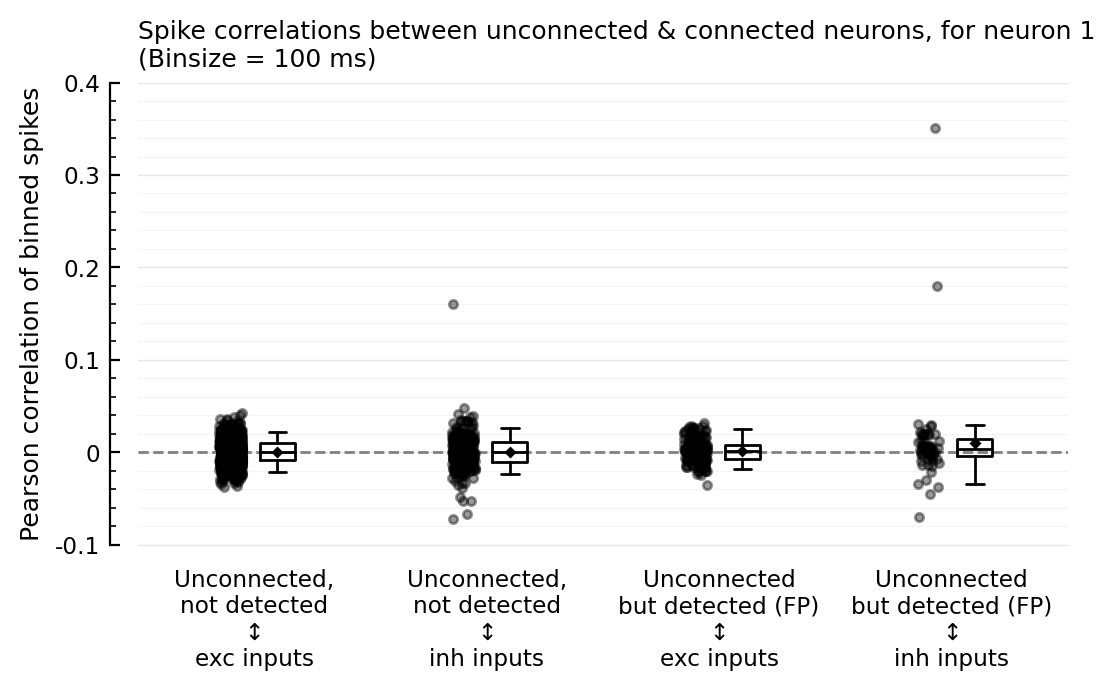

In [266]:
function corplot(; binsize)
    binned_spikes = [bin(s.spike_times[n], duration = 10minutes; binsize) for n in s.neuron_IDs];
    spikecors(group_A, group_B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in group_A, n in group_B]);
    ax = ydistplot(
        jn("Unconnected,", "not detected", "↕", "exc inputs") => spikecors(insignif_unconn, ii.exc_inputs),
        jn("Unconnected,", "not detected", "↕", "inh inputs") => spikecors(insignif_unconn, ii.inh_inputs),
        jn("Unconnected", "but detected (FP)", "↕", "exc inputs") => spikecors(signif_unconn, ii.exc_inputs),
        jn("Unconnected", "but detected (FP)", "↕", "inh inputs") => spikecors(signif_unconn, ii.inh_inputs),
        figsize = (6, 3),
        hylabel = jn("Spike correlations between unconnected & connected neurons, for neuron $m",
                     "(Binsize = $(binsize/ms) ms)"),
        ylabel = "Pearson correlation of binned spikes",
    )
    add_refline(ax, 0, zorder=1, c="gray")
    return ax
end
ax = corplot(binsize=100ms);

So the strong-correlation outliers are with inhibitory inputs.

And the (slightly) higher correlation seems to be for inh inputs, not exc.

But we must zoom in a bit:

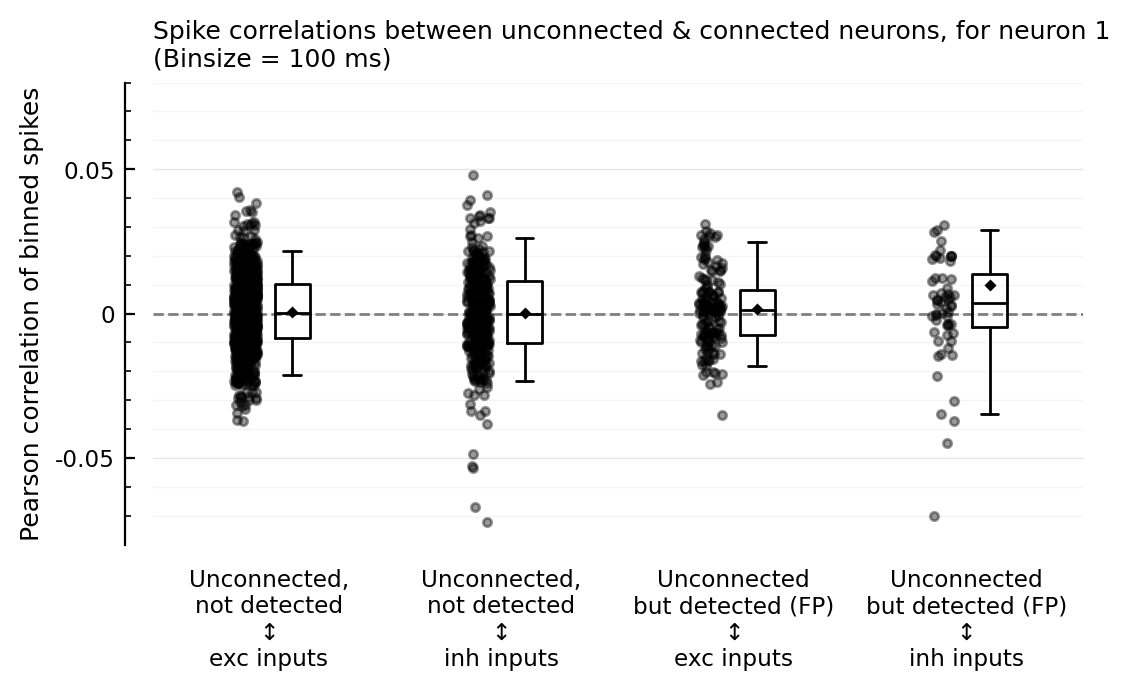

In [258]:
set(ax, ylim=(-0.08, 0.08), xtype=:keep)
ax.figure

We expected the FP correlations with exc to be higher.
But it's higher with inh.
That makes sense though as the inh→exc connections were better detected than the exc→exc. (neuron `1` is exc).

### Other binsizes

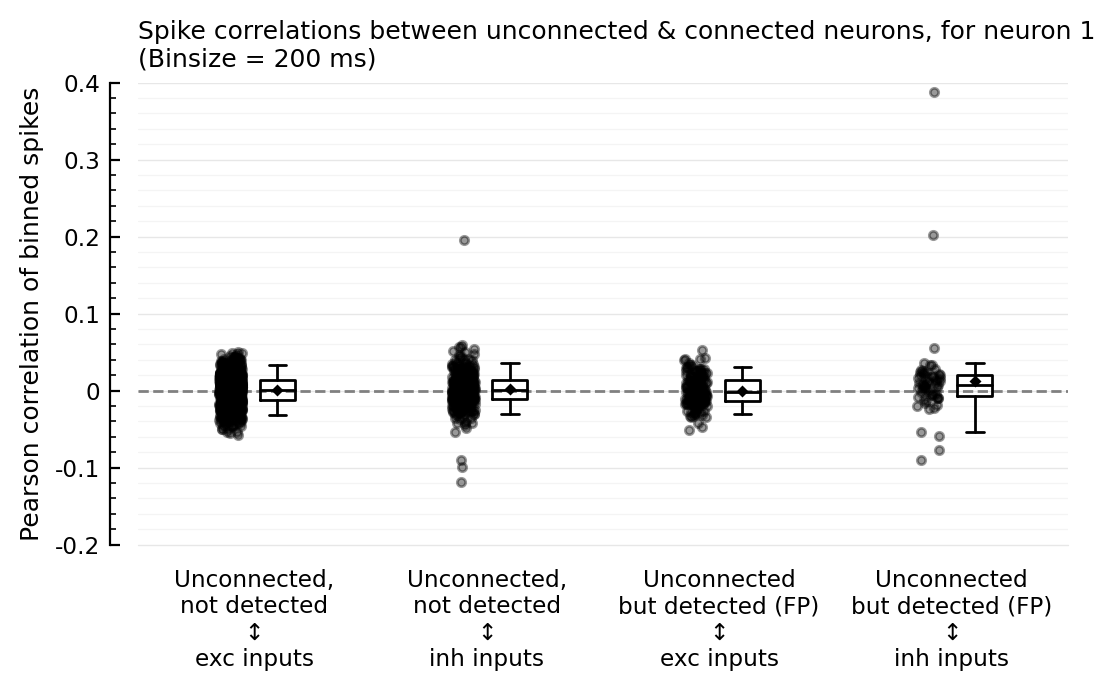

In [271]:
corplot(binsize=200ms);

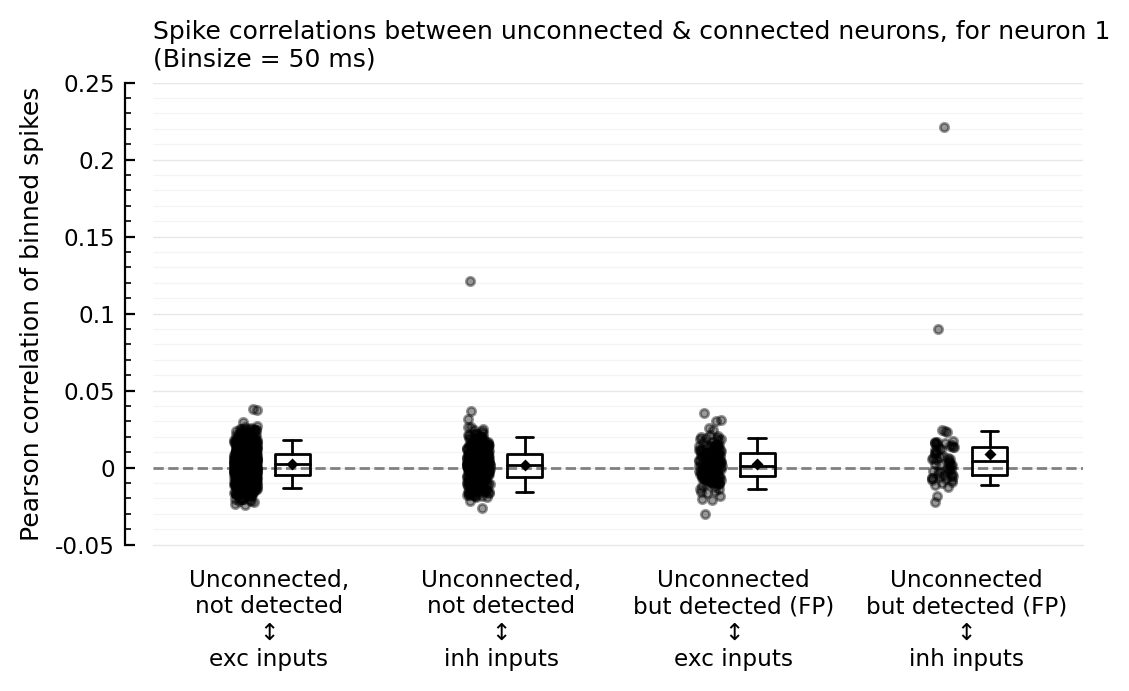

In [268]:
corplot(binsize=50ms);

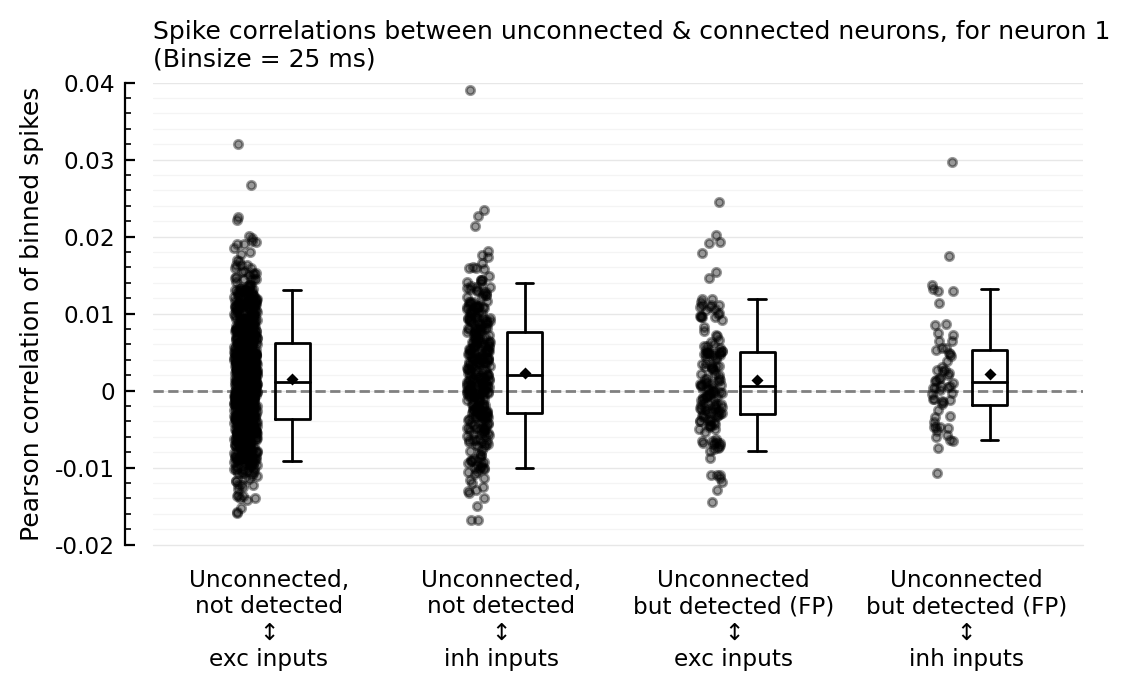

In [270]:
corplot(binsize=25ms);

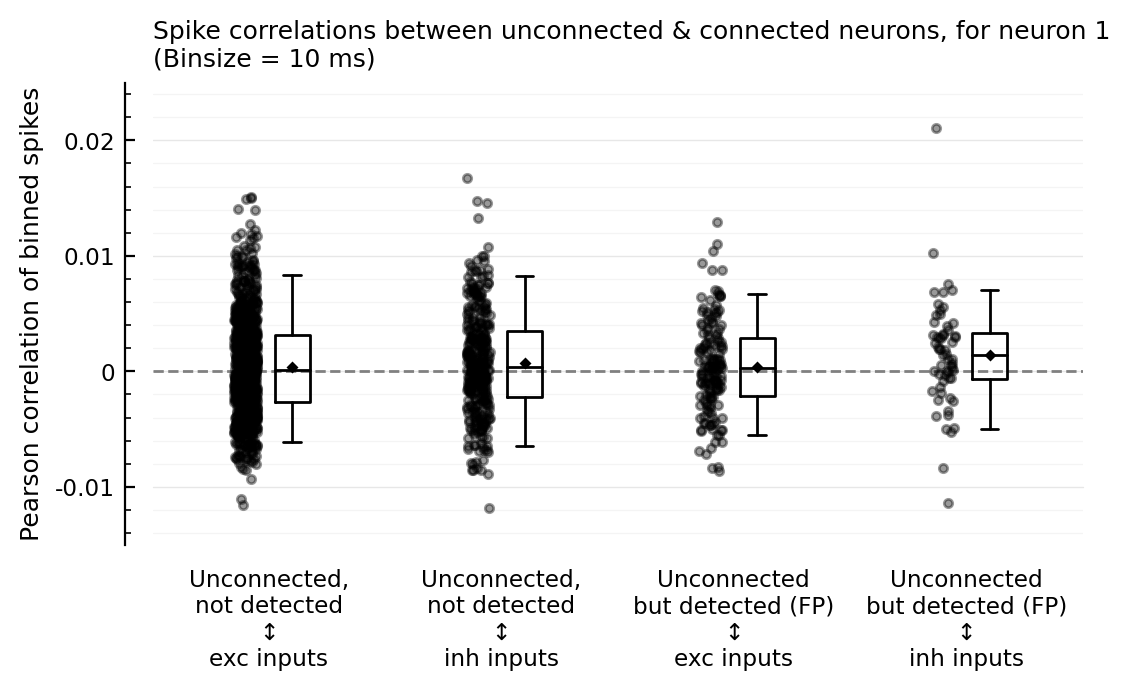

In [273]:
corplot(binsize=10ms);

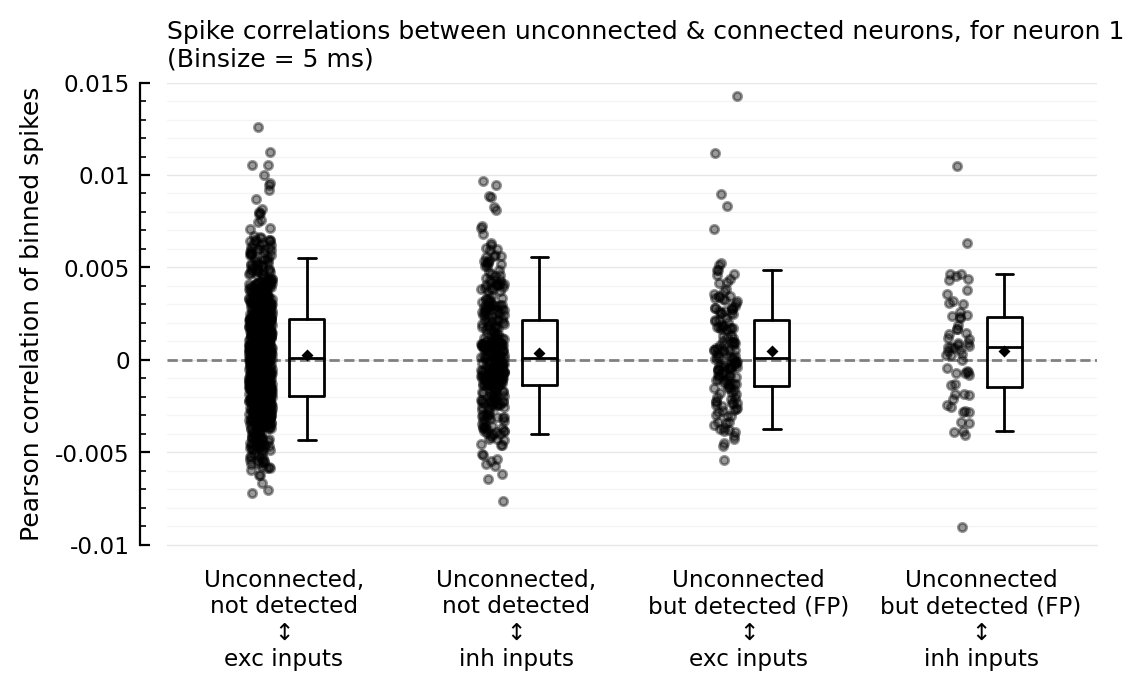

In [275]:
corplot(binsize=5ms);

So the outliers remain for binsizes 50 and 200, and the FP ↔ inh nonzero corr seems to too.
For binsize 25 ms however, both phenomena disappear; but then for 10 and 5 ms, the nonzero corr seems to be back.

## All spike correlations in network

We need to sample, as calculating 1000x1000 spiketrain correlations takes too long.

In [279]:
ns = sample(s.neuron_IDs, 100, replace=false);

In [308]:
spikecors_nosame(A,B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in A, n in B if m != n]);

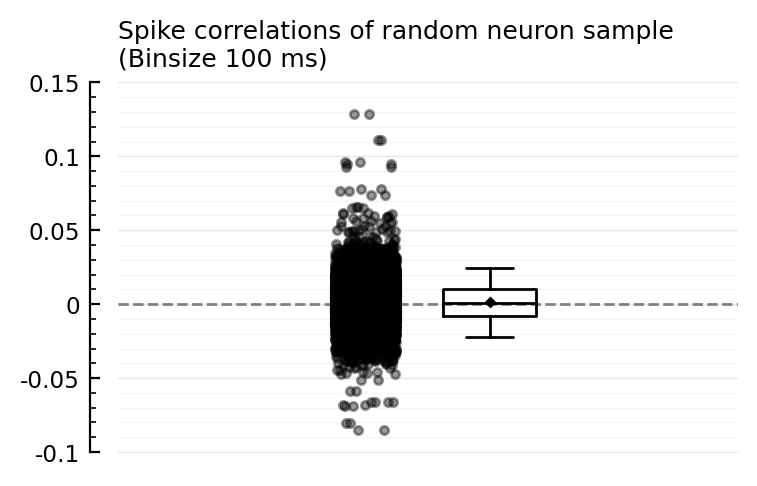

In [309]:
ydistplot(""=>spikecors_nosame(ns,ns), ref=0, hylabel=jn("Spike correlations of random neuron sample", "(Binsize 100 ms)"));

So the 0.15 to 0.35 outliers we saw are in fact rare.

Split by neuron types

In [310]:
ns_exc = [m for m in ns if m in s.neuron_IDs.exc]
ns_inh = [m for m in ns if m in s.neuron_IDs.inh];

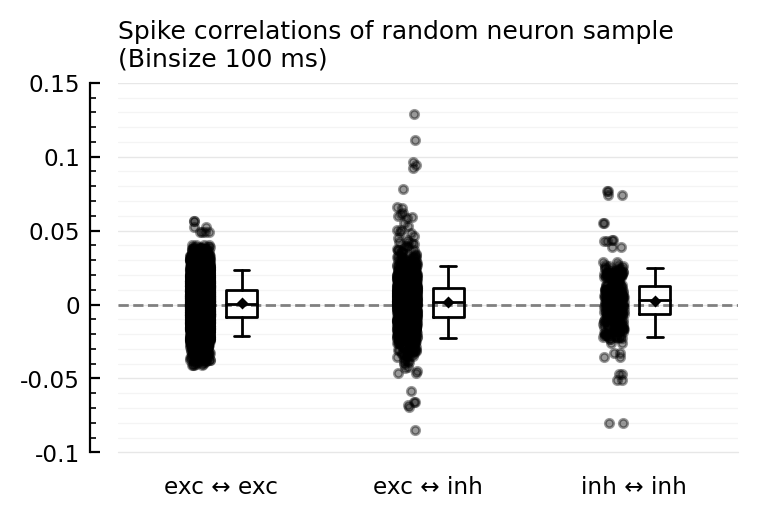

In [312]:
ydistplot(
    "exc ↔ exc" => spikecors_nosame(ns_exc, ns_exc),
    "exc ↔ inh" => spikecors_nosame(ns_exc, ns_inh),
    "inh ↔ inh" => spikecors_nosame(ns_inh, ns_inh),
    ref=0,
    hylabel=jn("Spike correlations of random neuron sample", "(Binsize 100 ms)")
);

inhibitory neurons seem on average to be more correlated with other neurons than excitatory neurons are.

## Investigate correlation outliers

What do their STA's and spiketrains look like?  
How are they connected in network?  
Why does that one have high cor but is still undetected?

Get neuron IDs.

In [324]:
IDs_with_high_cor(group_A, group_B) = [(m,n) for m in group_A, n in group_B if cor(binned_spikes[m], binned_spikes[n]) > 0.1];

In [325]:
IDs_with_high_cor(insignif_unconn, ii.inh_inputs)

1-element Vector{Tuple{Int64, Int64}}:
 (2, 831)

In [326]:
IDs_with_high_cor(signif_unconn, ii.inh_inputs)

2-element Vector{Tuple{Int64, Int64}}:
 (4, 928)
 (22, 829)

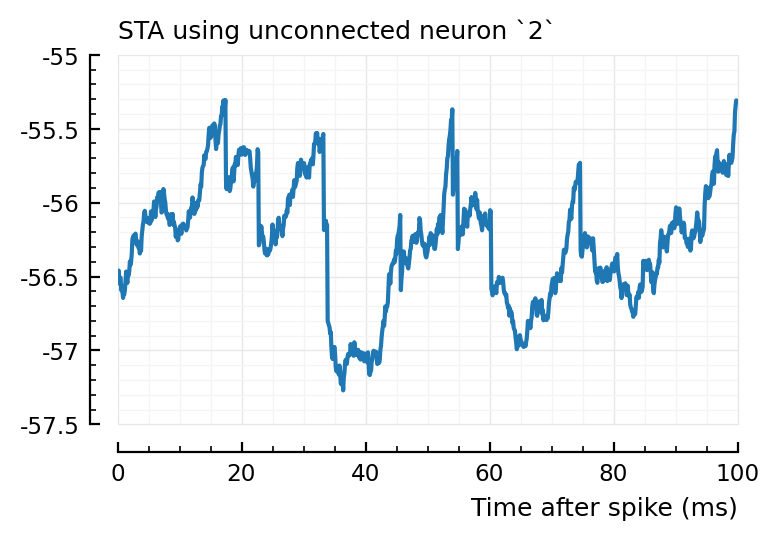

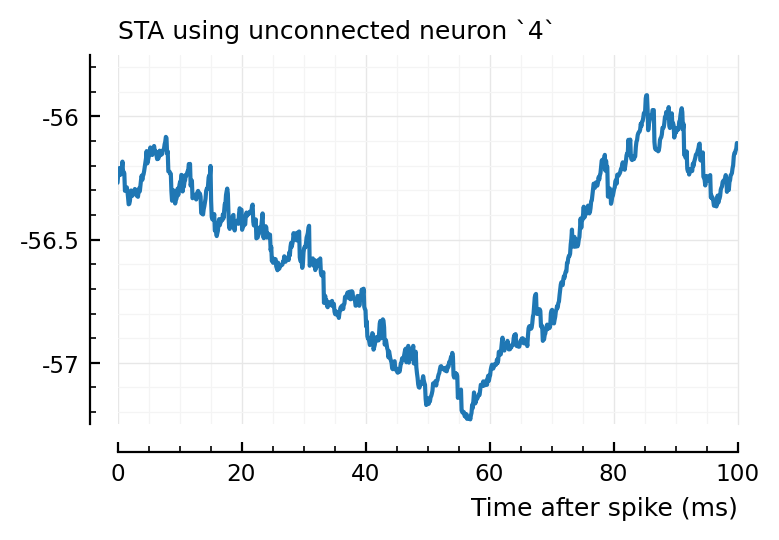

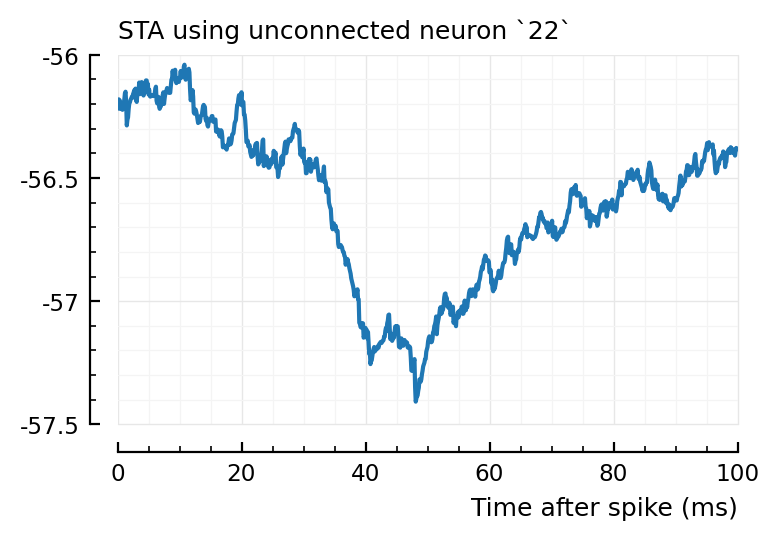

In [393]:
for n in (2, 4, 22)
    plotSTA(v, s.spike_times[n], p, hylabel="STA using unconnected neuron `$n`")
end;

Ok, so STA wise it makes sense the first one (2) is not detected, and the other two are.

Now I wanna compare the spiking of those pairs. "Look behind" those corr numbers.

First, are they directly connected?

In [345]:
2 in s.input_neurons[831]

true

In [344]:
4 in s.input_neurons[928]

true

In [346]:
22 in s.input_neurons[829]

true

Yes, all three are.

Maybe a cross-correlogram.

### Cross-correlograms

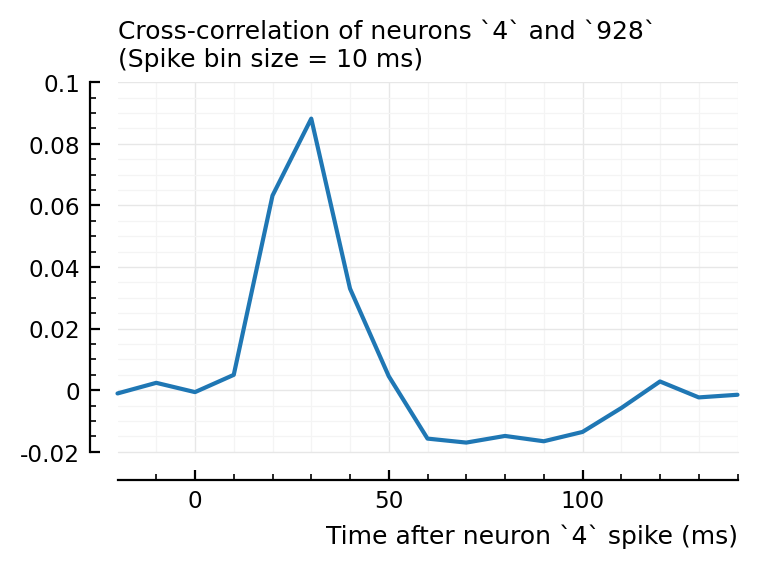

In [375]:
function plotxc(m, n; binsize = 10ms)
    duration = 10minutes
    x = bin(s.spike_times[m]; binsize, duration)
    y = bin(s.spike_times[n]; binsize, duration)
    lags = -2:14
    xc = crosscor(x,y, lags);
    plotsig(
        lags*binsize/ms,
        xc,
        hylabel=jn("Cross-correlation of neurons `$m` and `$n`", "(Spike bin size = $(binsize/ms) ms)"),
        xlabel="Time after neuron `$m` spike (ms)",
    )
end
plotxc(4, 928);

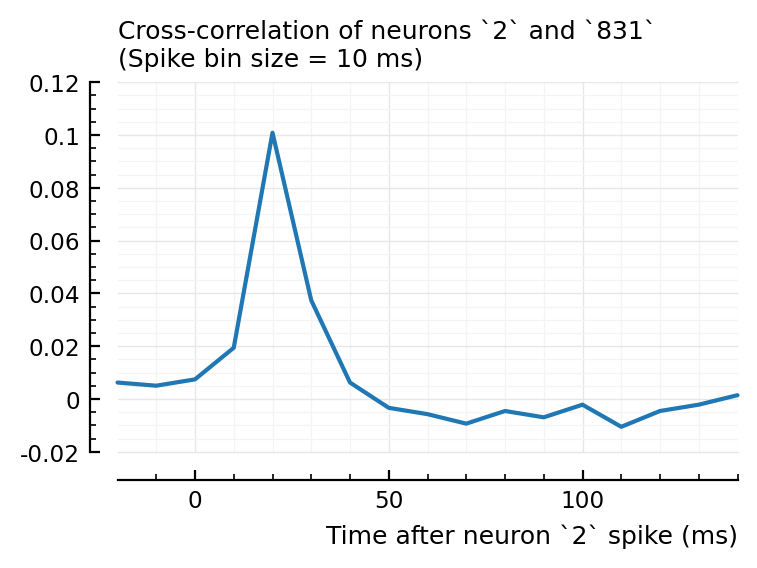

In [376]:
plotxc(2, 831);  # the undetected one

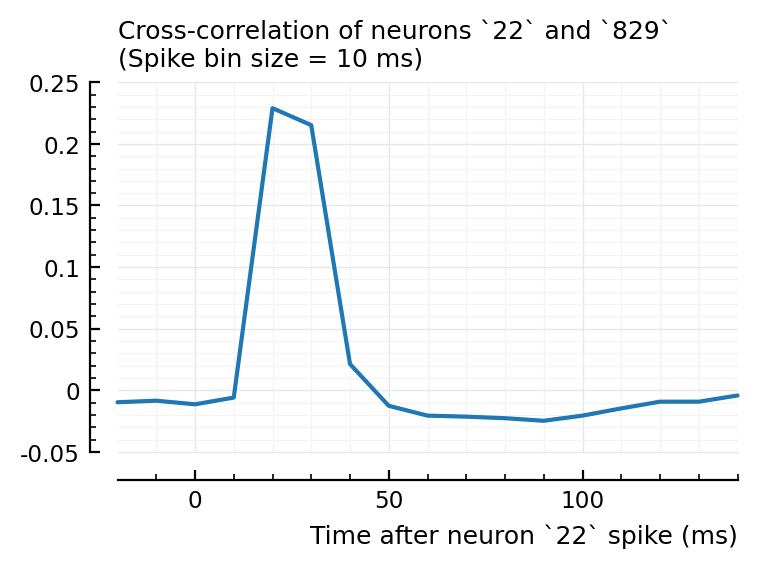

In [377]:
plotxc(22, 829);

So interestingly, unconnected neuron 2 is highly correlated with connected, inhibitory neuron 831. Yet it's STA is noisy.

Plot STA of that inhibitory input:

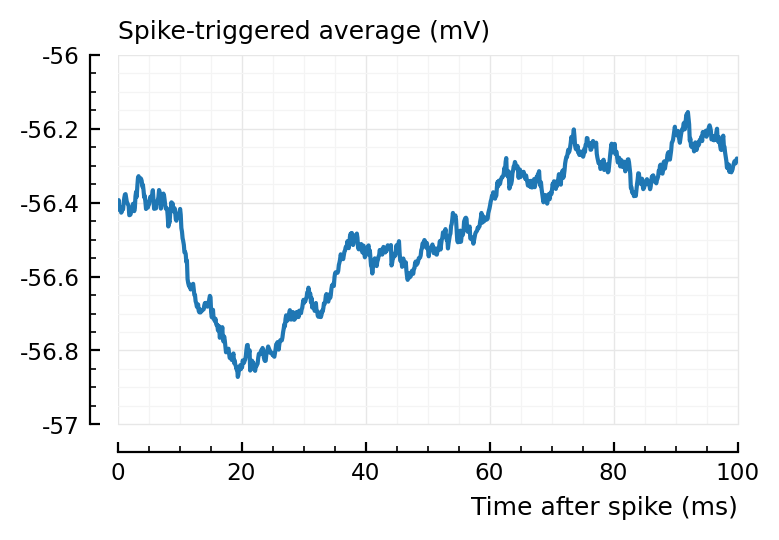

In [395]:
plotSTA(v, s.spike_times[831], p);

Aha, this STA is not so strong..

To compare, the other two inh inputs here:

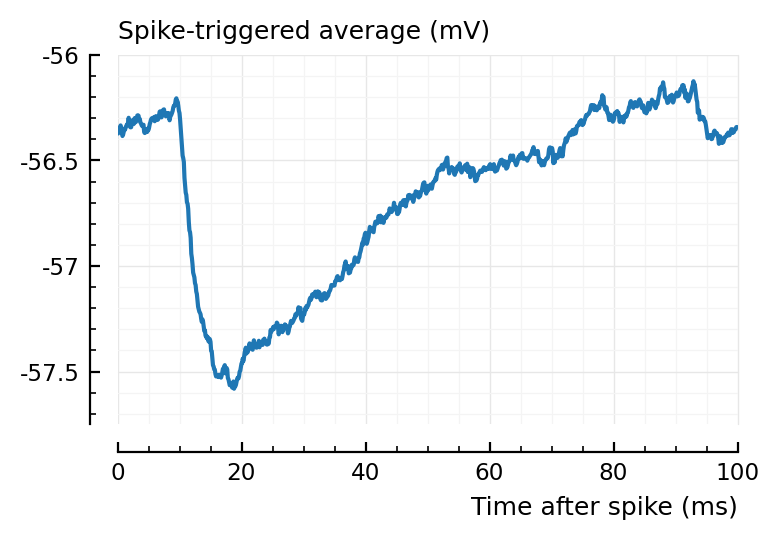

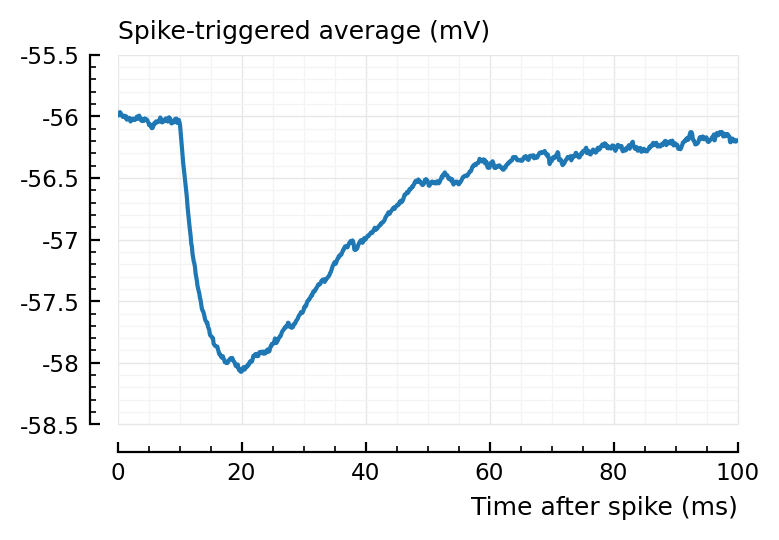

In [397]:
plotSTA(v, s.spike_times[829], p);
plotSTA(v, s.spike_times[928], p);

They're stronger.

Was the 831 even detected?

In [401]:
perf.p_values.conn.inh[findfirst(ii.inh_inputs .== 831)]

0.01

Ok yes it was.

Maybe 831 just fires less, or has weaker connection weight.

In [411]:
[n => s.spike_rates[n] for n in [831, 829,928]]

3-element Vector{Pair{Int64, Float64}}:
 831 => 8.8
 829 => 6.09
 928 => 8.94

Ok so not firing less.

(For weights: should edit this in init: save (pre,post) => syn ID mapping). (And then clear cache).

In [410]:
pre_post_pairs = Tuple.(findall(s.is_connected))
for ((pre,post), ss) in zip(pre_post_pairs, s.syn_strengths / nS)
    if (pre,post) in [
        (2, 831),
        (4, 928),
        (22, 829),
    ]
        println("Synapse strength from $pre to $post: $ss")
    end
end

Synapse strength from 22 to 829: 8.82
Synapse strength from 2 to 831: 12.5
Synapse strength from 4 to 928: 4.42


..and also not a weaker weight (on the contrary).
Hm.

So, I don't know why 2→831 has high corr and xcorr, but is not detected,
while 4→928 and 22→829 are.

---

Most FP neurons did not have high cor (with binsize 100ms). But maybe they have high xcor.

Hm, don't immediately see how to choose which to plot.

---

Btw: actually connected inputs do not have strong xcorr with recorded neuron:

In [388]:
rec_neuron = 1;

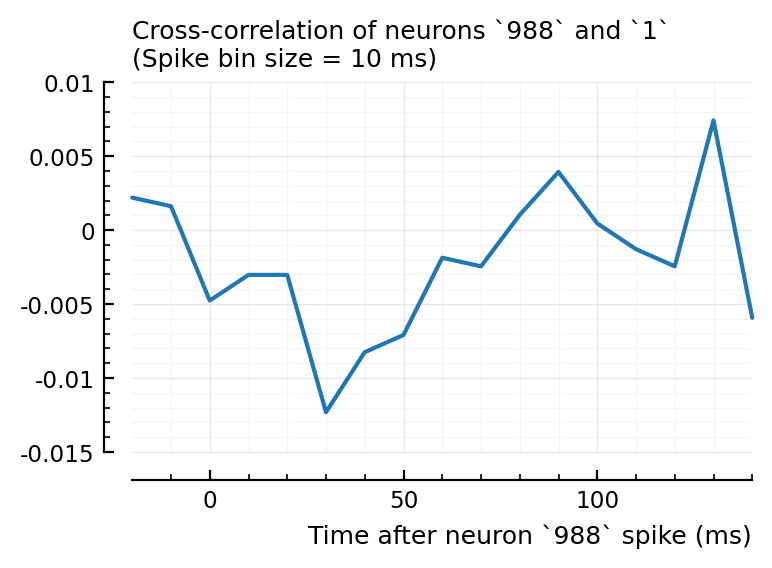

In [390]:
plotxc(ii.inh_inputs[1], rec_neuron);

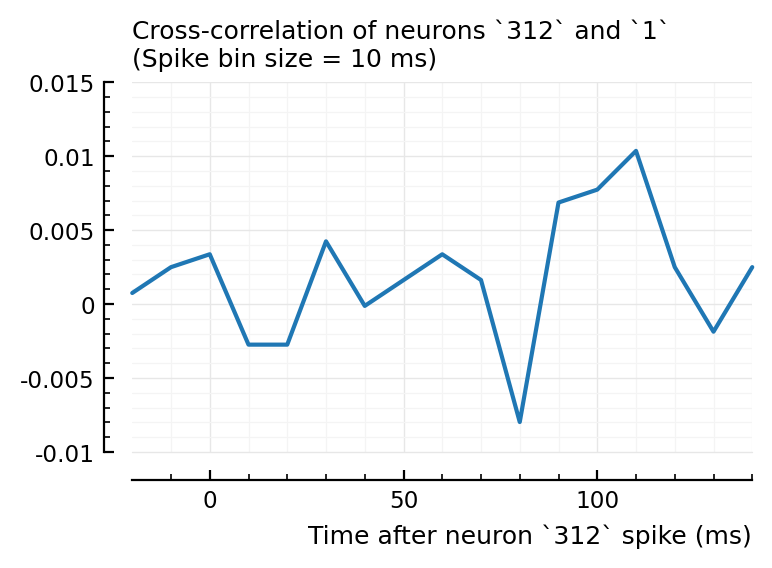

In [391]:
plotxc(ii.exc_inputs[1], rec_neuron);

This is a basic spikes-only conndet (network inference) method. Which here does not seem to work at first sight.

(Test some others, namely the ones found above)

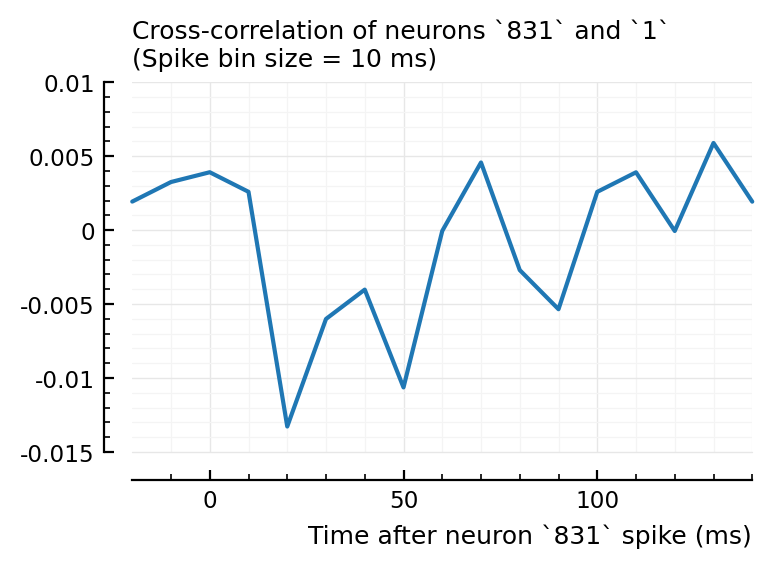

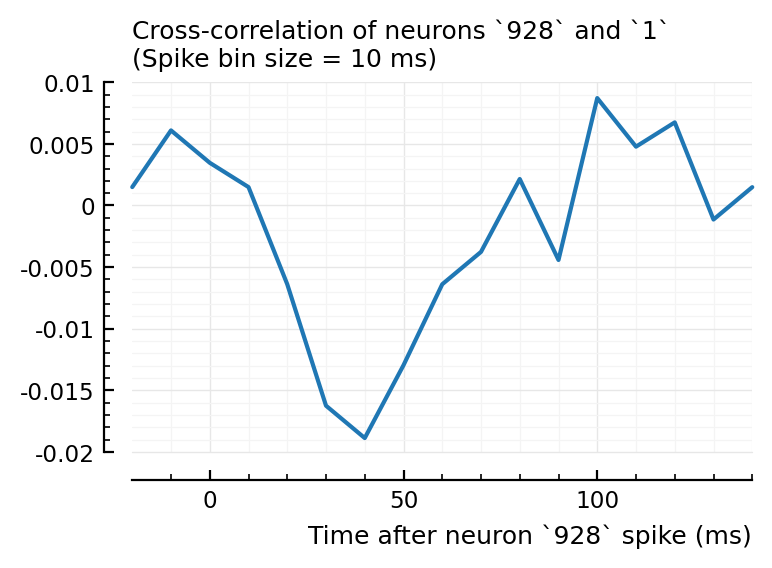

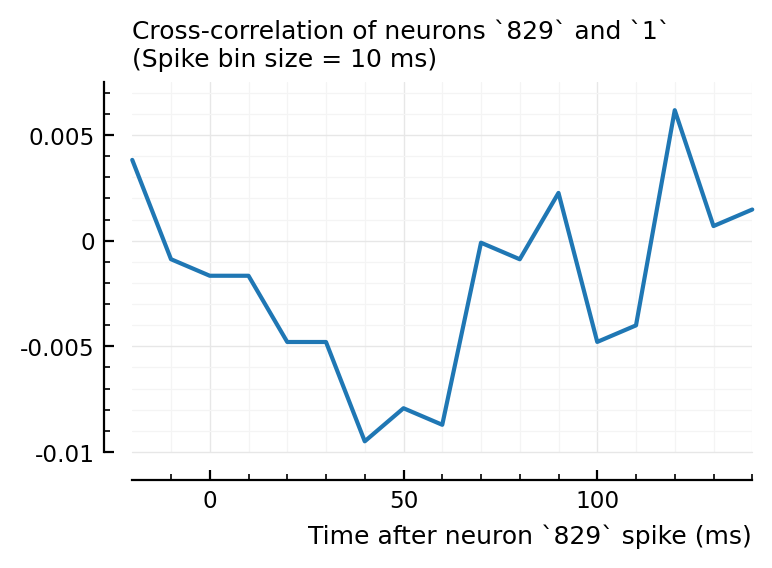

In [419]:
plotxc(831, rec_neuron); plt.subplots()
plotxc(928, rec_neuron); plt.subplots()
plotxc(829, rec_neuron);